# Part 6: Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

## Start with the neccessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

2024-10-21 11:04:15.202395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 11:04:15.263497: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/ck/anaconda3/envs/hls4ml-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the SVHN dataset using Tensorflow Dataset

In this part we will fetch the trainining, validation and test dataset using Tensorflow Datasets (https://www.tensorflow.org/datasets). We will not use the 'extra' training in order to save time, but you could fetch it by adding `split='train[:90%]+extra'`. We will use the first 90% of the training data for training and the last 10% for validation.

2024-10-21 11:04:16.720994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 11:04:16.777042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2259 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:65:00.0, compute capability: 7.5


Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


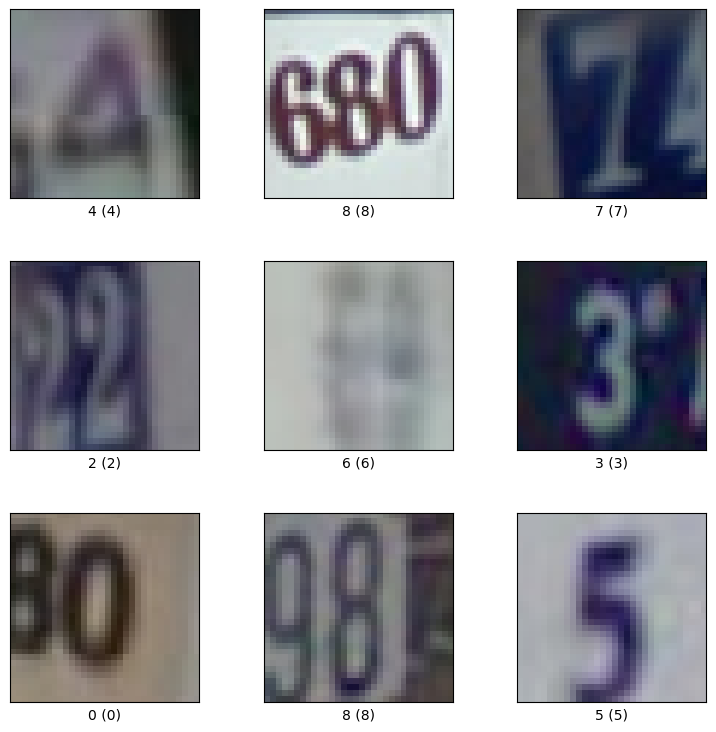

In [2]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

We'll use TensorFlow Dataset to prepare our datasets. We'll fetch the training dataset as tuples, and the test dataset as numpy arrays

In [3]:
def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

In [4]:
batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))
print("Y_test [1]", Y_test[1])

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 
Y_test [1] tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)


## Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 16)        432       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 30, 30, 16)       64        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (N

Lets check if this model can be implemented completely unrolled (=parallel)

In [6]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 432
conv_1: 2304
conv_2: 3456
dense_0: 4032
dense_1: 2688
output_dense: 640


Looks good! It's below the Vivado-enforced unroll limit of 4096.

## Prune dense and convolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 64
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train baseline

We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In [8]:
train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))

    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30


2024-10-21 11:04:21.357045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-21 11:04:21.682528: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x74b525e43670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-21 11:04:21.682551: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-10-21 11:04:21.685578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 11:04:21.761070: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 [==============================] - 7s 38ms/step - loss: 1.4774 - accuracy: 0.5522 - val_loss: 2.0184 - val_accuracy: 0.3503 - lr: 0.0030
Epoch 2/30
65/65 [==============================] - 2s 30ms/step - loss: 0.6970 - accuracy: 0.8223 - val_loss: 1.9217 - val_accuracy: 0.4020 - lr: 0.0030
Epoch 3/30
65/65 [==============================] - 2s 29ms/step - loss: 0.5686 - accuracy: 0.8610 - val_loss: 1.5420 - val_accuracy: 0.5344 - lr: 0.0030
Epoch 4/30
65/65 [==============================] - 2s 28ms/step - loss: 0.5161 - accuracy: 0.8751 - val_loss: 1.2520 - val_accuracy: 0.6213 - lr: 0.0030
Epoch 5/30
65/65 [==============================] - 2s 28ms/step - loss: 0.4807 - accuracy: 0.8837 - val_loss: 1.2517 - val_accuracy: 0.6429 - lr: 0.0030
Epoch 6/30
65/65 [==============================] - 2s 29ms/step - loss: 0.4584 - accuracy: 0.8885 - val_loss: 0.7600 - val_accuracy: 0.7920 - lr: 0.0030
Epoch 7/30
65/65 [==============================] - 2s 29ms/step - loss: 0.4379 - accur

You'll notice the accuracy is lower than that in the hls4ml CNN paper (https://arxiv.org/abs/2101.05108) despite the model being the same. The reson for this is that we didn't use the ``extra`` training data in order to save time. If you want to futher optimize the network, increasing the training data is a good place to start. Enlarging the model architecture comes at a high latency/resource cost.

## Quantization and the fused Conv2D+BatchNormalization layer in QKeras
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. 
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<6,1>`` in hls4ml, due to the missing sign-bit). For now, make sure to set ```use_bias=True``` in ```QConv2DBatchnorm``` to avoid problems during synthesis.

In [9]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 fused_convbn_0 (QConv2DBatc  (None, 30, 30, 16)       513       
 hnorm)                                                          
                                                                 
 conv_act_0 (QActivation)    (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 16)        0         
                                                                 
 fused_convbn_1 (QConv2DBatc  (Non

In [10]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='1'``. This sets the weight scale per channel to 1 (no scaling). The default is ``alpha='auto_po2'``, which sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.

Let's now prune and train this model! If you want, you can also train the unpruned version, ``qmodel`` and see how the performance compares. We will stick to the pruned one here. Again, we do not use a model checkpoint which stores the best weights, in order to ensure the model is trained to the desired sparsity.

In [11]:
qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

In [12]:
train = True

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30


2024-10-21 11:05:26.842371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/qkeras/conv_act_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - 10s 99ms/step - loss: 2.2252 - accuracy: 0.2570 - val_loss: 2.3125 - val_accuracy: 0.1996 - lr: 0.0030
Epoch 2/30
65/65 [==============================] - 6s 92ms/step - loss: 1.4912 - accuracy: 0.5499 - val_loss: 1.7445 - val_accuracy: 0.4431 - lr: 0.0030
Epoch 3/30
65/65 [==============================] - 6s 92ms/step - loss: 0.9970 - accuracy: 0.7201 - val_loss: 1.7006 - val_accuracy: 0.4723 - lr: 0.0030
Epoch 4/30
65/65 [==============================] - 6s 92ms/step - loss: 0.8088 - accuracy: 0.7812 - val_loss: 1.7227 - val_accuracy: 0.4674 - lr: 0.0030
Epoch 5/30
65/65 [==============================] - 6s 92ms/step - loss: 0.7187 - accuracy: 0.8074 - val_loss: 1.2910 - val_accuracy: 0.5956 - lr: 0.0030
Epoch 6/30
65/65 [==============================] - 6s 92ms/step - loss: 0.6698 - accuracy: 0.8204 - val_loss: 1.0673 - val_accuracy: 0.6784 - lr: 0.0030
Epoch 7/30
65/65 [==============================] - 6s 92ms/step - loss: 0.6811 - accu